In [9]:
import sys
sys.path.insert(0, '/home/tchari/monod/src/')

In [10]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

In [31]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import scipy.stats

import anndata 

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

import os
import glob 
import hdbscan
import sklearn

In [12]:
from scipy.cluster.hierarchy import leaves_list, optimal_leaf_ordering
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import to_hex
from sklearn.utils import shuffle

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## **Make filepaths for inputs and outputs**

In [ ]:
#read in adata with metadata

meta_path = "/home/tchari/metadata/"
adata = anndata.read_h5ad(meta_path+'gehring_multiplex.h5ad')

In [38]:
np.unique(adata.obs['assignments'])

array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38',
       '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58',
       '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68',
       '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78',
       '79', '8', '80', '81', '82', '84', '85', '86', '87', '88', '89',
       '9', '90', '91', '92', '94', '95'], dtype=object)

In [45]:
controls_combo = [['11','23']]
remain = [[str(i)] for i in range(96) if (i != 11 and i != 23)]
all_conds = remain+controls_combo

loom_filepaths = ['/home/tchari/counts/gehring_nsc/loom/nsc_all.loom']*len(all_conds)

dataset_names = ['nsc_'+'_'.join(n) for n in all_conds] #To save
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = dataset_names
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]


n_datasets = len(loom_filepaths)

len(dataset_names):  95



## **Process Cell Barcodes**

Dataset nsc_0. 
	21232 barcodes in loom, 21063 pass filter. 21232 in annotations; of these, 21232 in loom and 21063 in filtered loom.
	['0']: 21 cells in annotations. 21 in loom. 21 pass filter.
	['1']: 73 cells in annotations. 73 in loom. 73 pass filter.
	['2']: 63 cells in annotations. 63 in loom. 63 pass filter.
	['3']: 114 cells in annotations. 114 in loom. 114 pass filter.
	['4']: 104 cells in annotations. 104 in loom. 104 pass filter.
	['5']: 23 cells in annotations. 23 in loom. 23 pass filter.
	['6']: 130 cells in annotations. 130 in loom. 129 pass filter.
	['7']: 76 cells in annotations. 76 in loom. 74 pass filter.
	['8']: 975 cells in annotations. 975 in loom. 972 pass filter.
	['9']: 17 cells in annotations. 17 in loom. 14 pass filter.
	['10']: 6 cells in annotations. 6 in loom. 6 pass filter.
	['12']: 71 cells in annotations. 71 in loom. 71 pass filter.
	['13']: 68 cells in annotations. 68 in loom. 68 pass filter.
	['14']: 57 cells in annotations. 57 in loom. 57 pass filter.

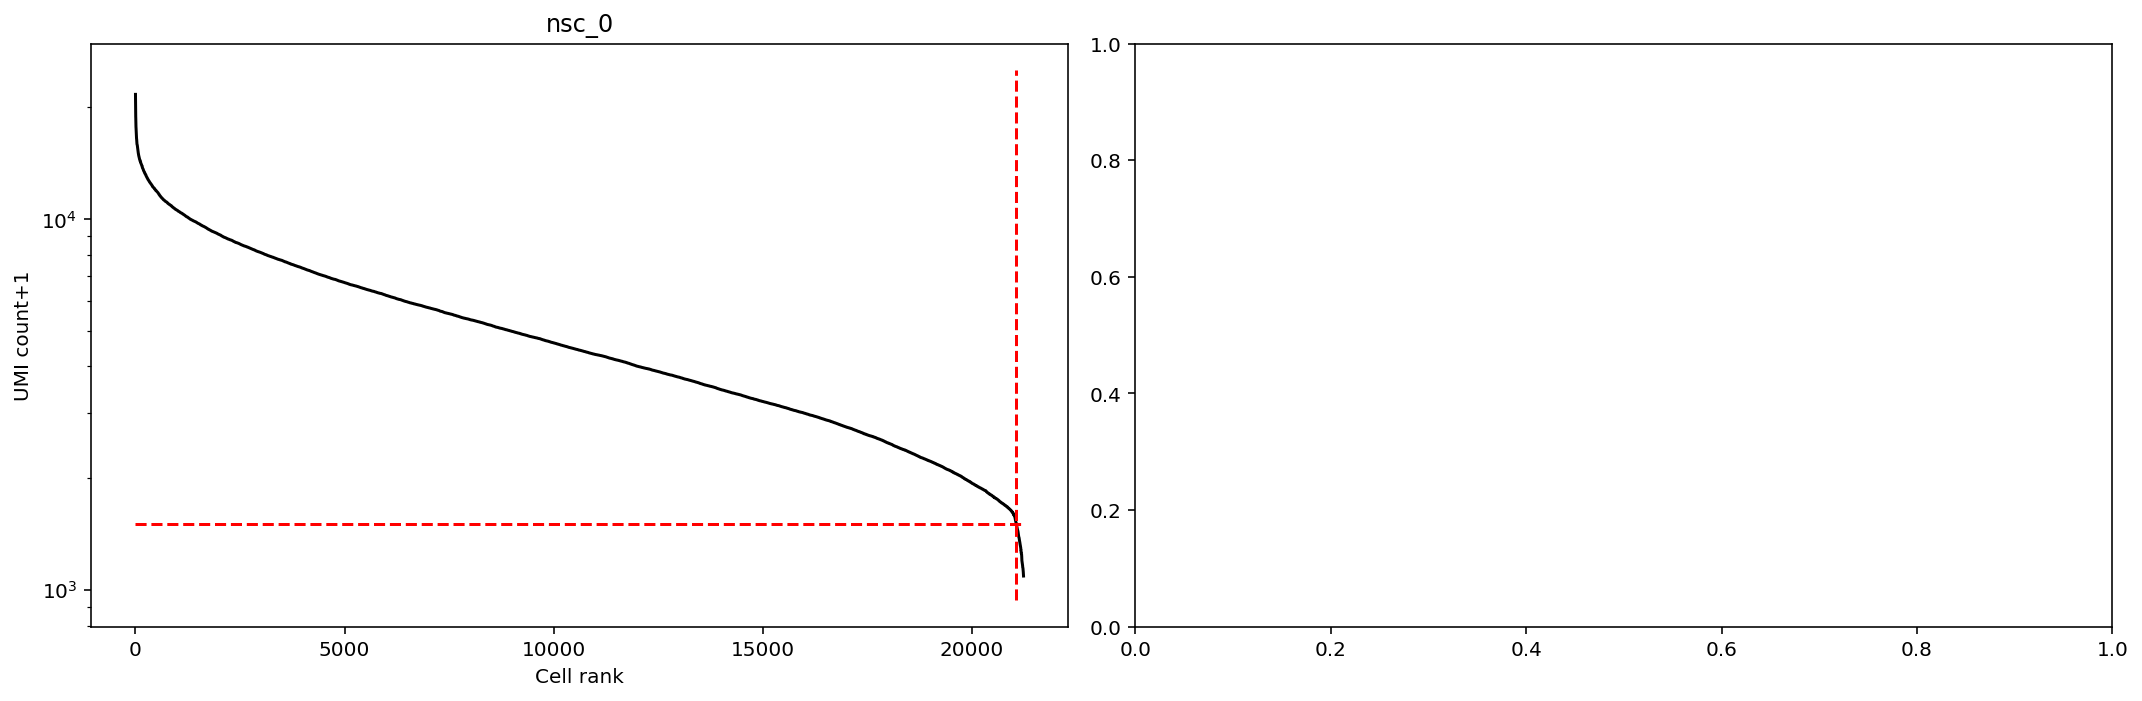

In [49]:
cf = []
thr_lb = [1.5e3]*2

fig1,ax1 = plt.subplots(1,2,figsize=(15,5))

for k in range(1):
    filename = loom_filepaths[k]
    dataset_name = raw_data_locations[k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = len(adata.obs_names)
        annot_bcs_in_loom = adata.obs_names.isin(bcs).sum()
        annot_bcs_in_filt_loom = adata.obs_names.isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        #if k==0:
        for subcluster in all_conds:
            annot_bcs = adata[(adata.obs['assignments'].isin(subcluster))].obs_names
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_all_gehring.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

## **Select Genes for Inference**

In [50]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [51]:
!mkdir ./fits

mkdir: cannot create directory ‘./fits’: File exists


INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230903_025_gehring_1 created.
INFO:root:Dataset: nsc_0
INFO:root:21 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:2 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230903_025_gehring_1/nsc_0 created.
INFO:root:Dataset: nsc_1
INFO:root:73 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:2 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230903_025_gehring_1/nsc_1 created.
INFO:root:Dataset: nsc_2
INFO:root:63 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:4 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230903_025_gehring_1/nsc_2 created.
INFO:root:Dataset: nsc_3
INFO:root:114 cells detected.
INFO:root:32285 features observed, 32005 match genome ann

/home/tchari/monod/src/monod/preprocess.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))


INFO:root:196 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:10 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230903_025_gehring_1/nsc_22 created.
INFO:root:Dataset: nsc_24
INFO:root:85 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:3 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230903_025_gehring_1/nsc_24 created.
INFO:root:Dataset: nsc_25
INFO:root:108 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:4 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230903_025_gehring_1/nsc_25 created.
INFO:root:Dataset: nsc_26
INFO:root:54 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:1 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230903_025_gehring_1

INFO:root:9 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230903_025_gehring_1/nsc_54 created.
INFO:root:Dataset: nsc_55
INFO:root:102 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:3 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230903_025_gehring_1/nsc_55 created.
INFO:root:Dataset: nsc_56
INFO:root:112 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:4 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230903_025_gehring_1/nsc_56 created.
INFO:root:Dataset: nsc_57
INFO:root:12 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:0 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230903_025_gehring_1/nsc_57 created.
INFO:root:Dataset: nsc_58
INFO:root:8 cells detected.
INFO:root:32285 features observed, 32005 matc

ValueError: zero-size array to reduction operation maximum which has no identity

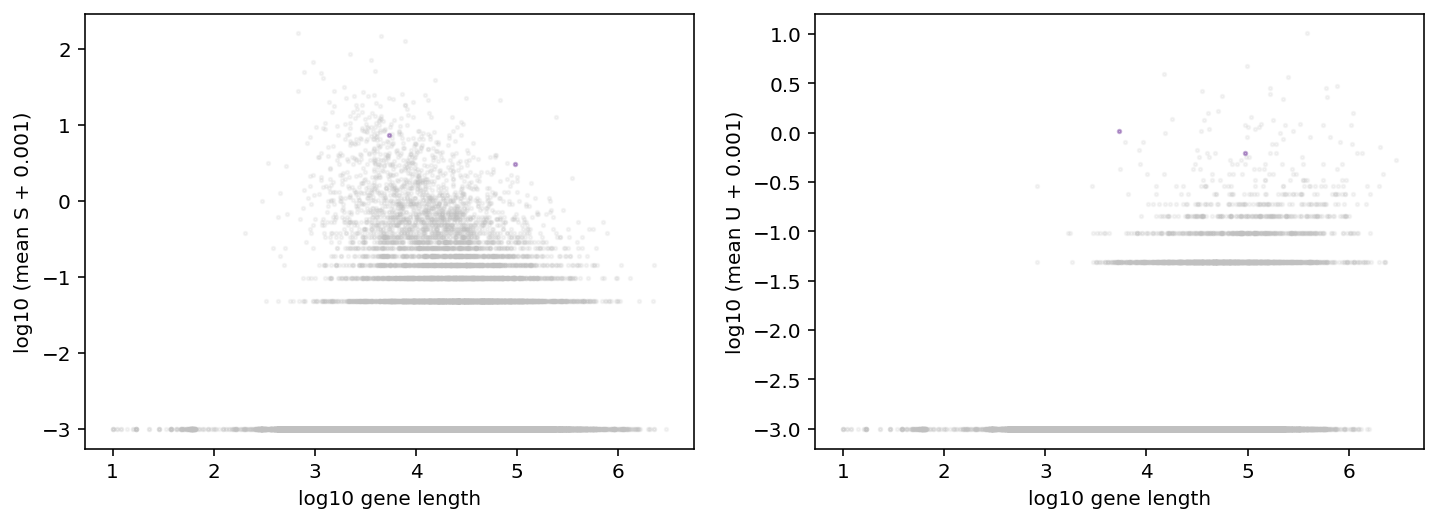

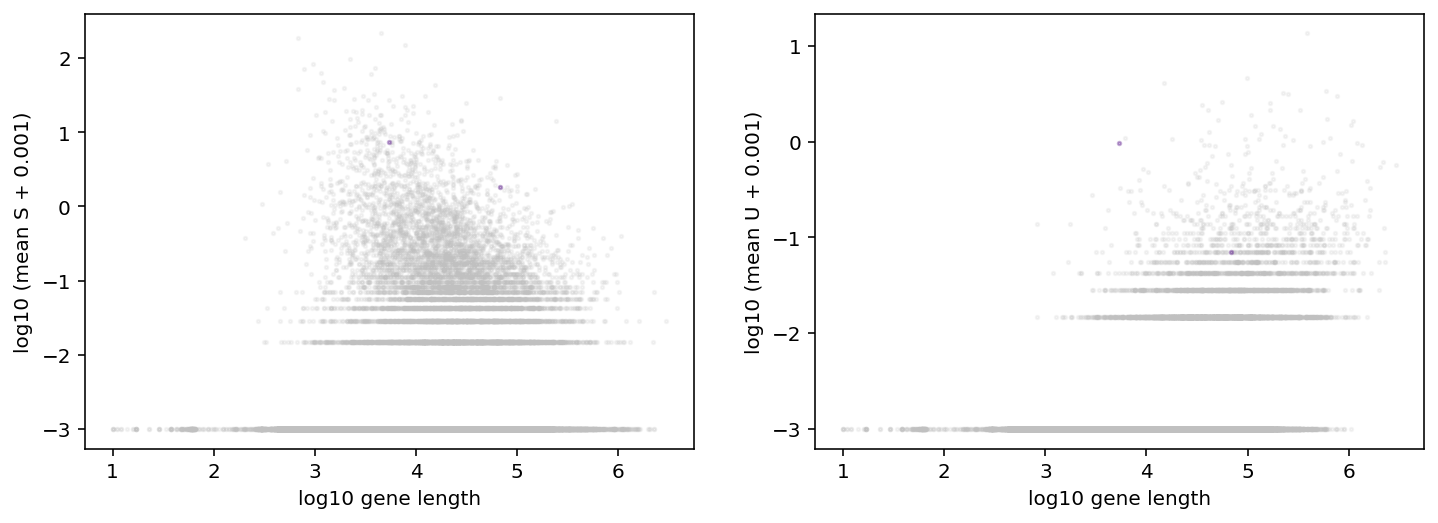

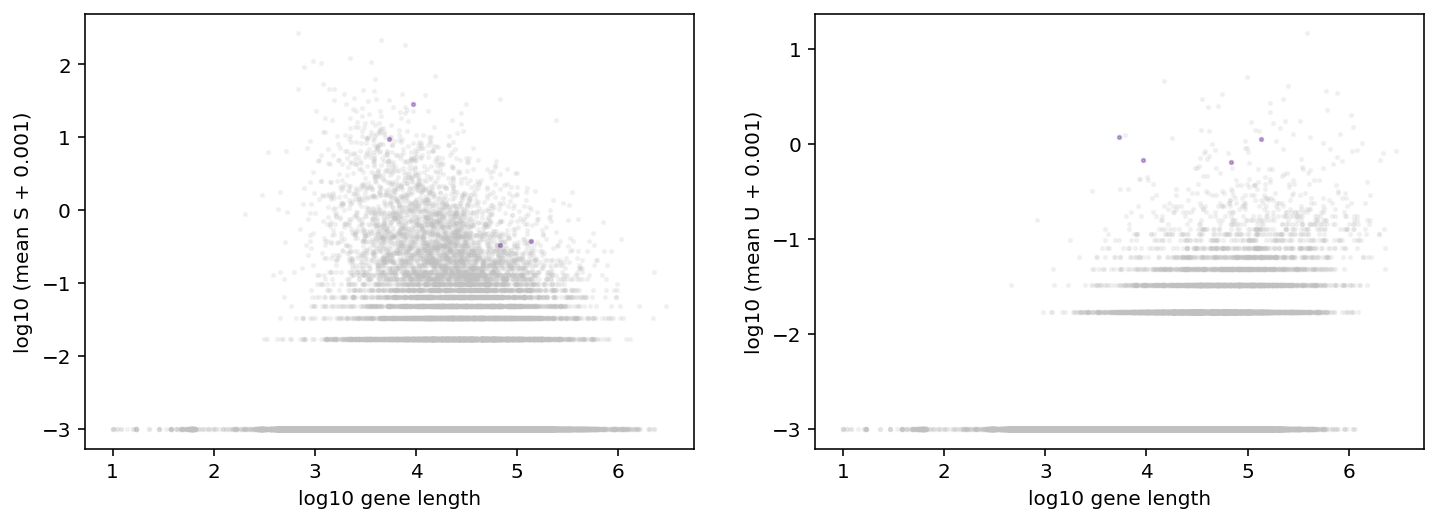

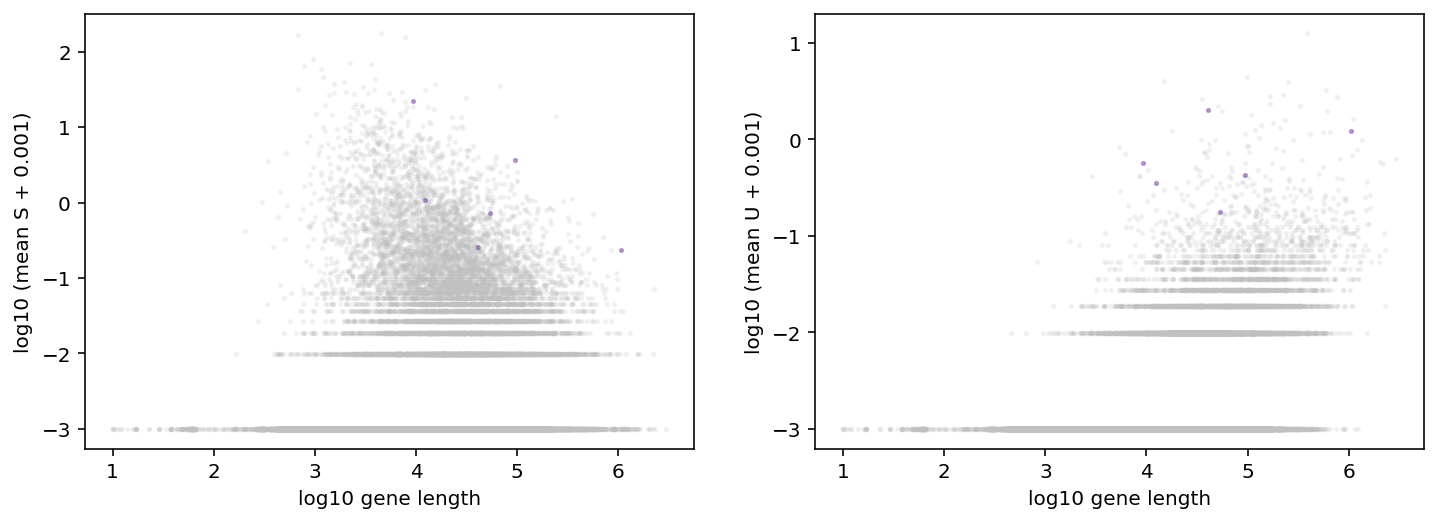

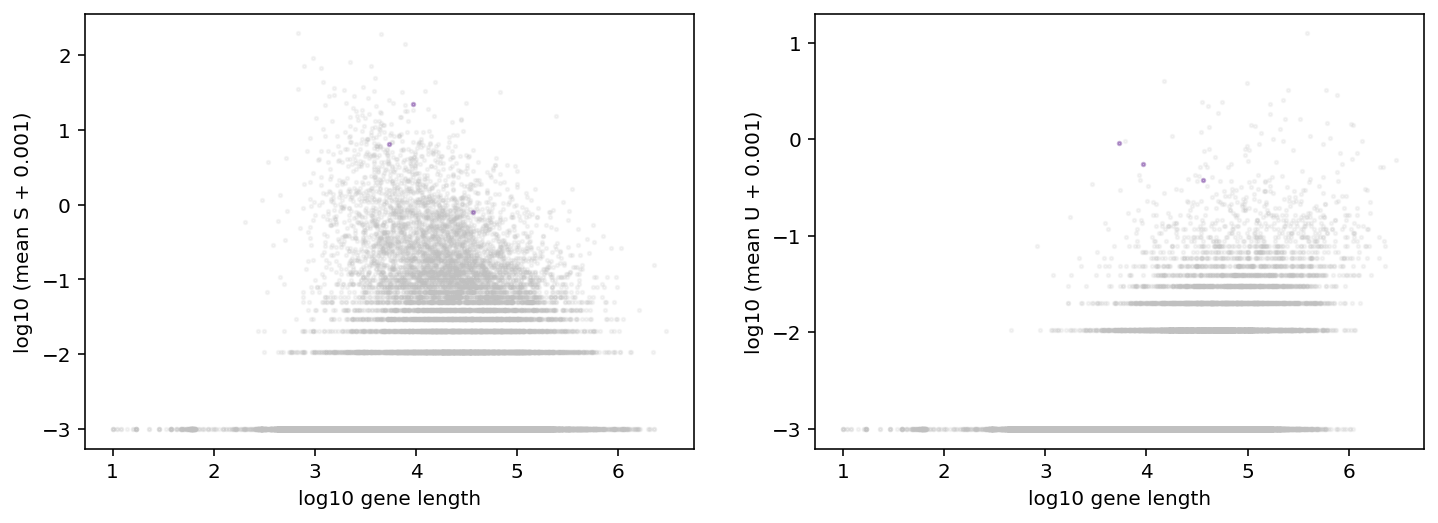

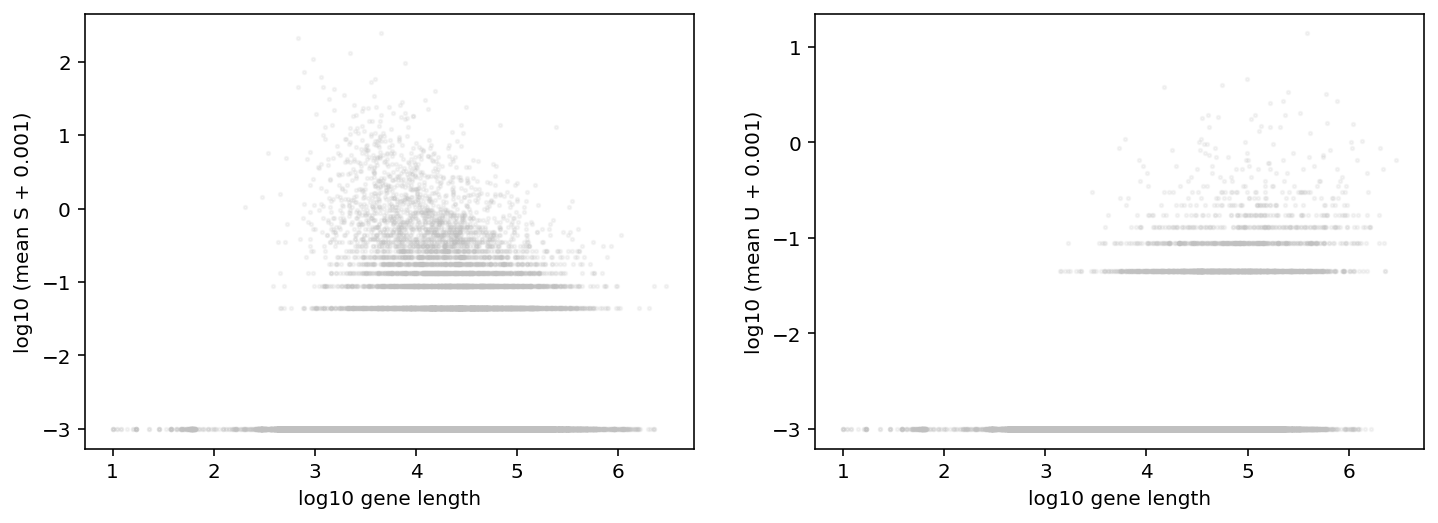

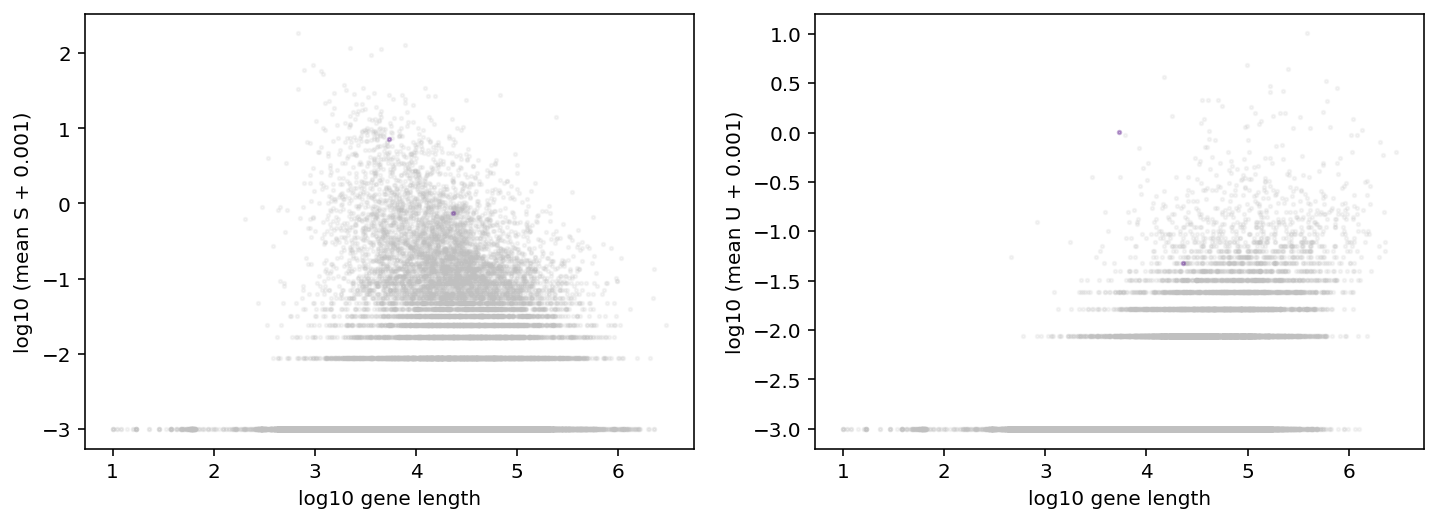

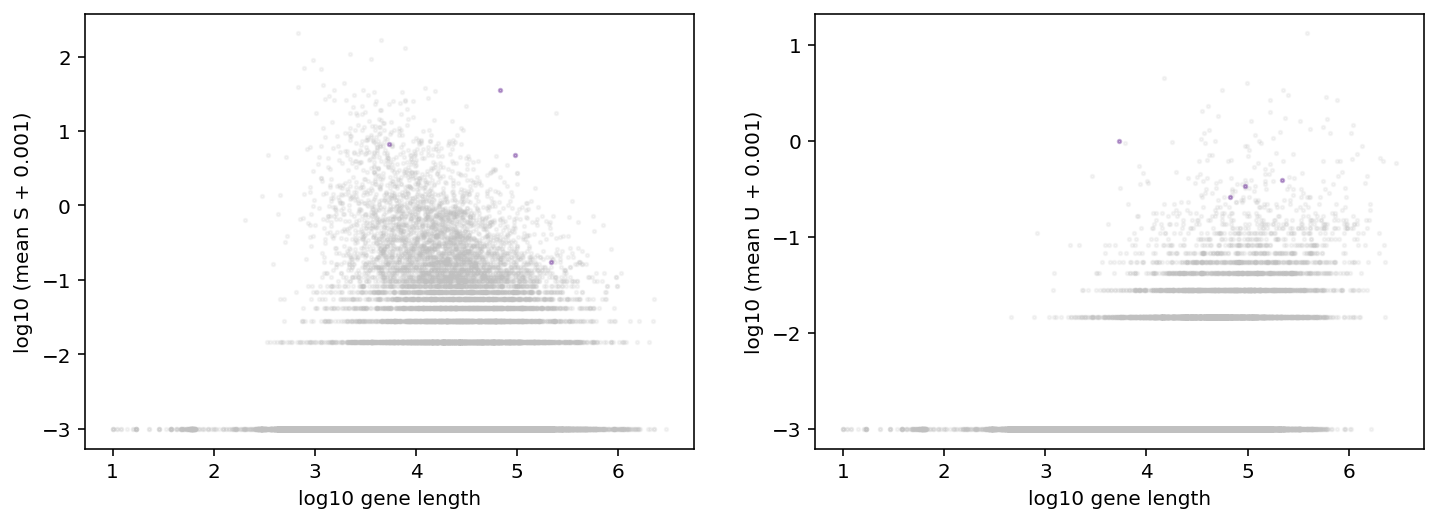

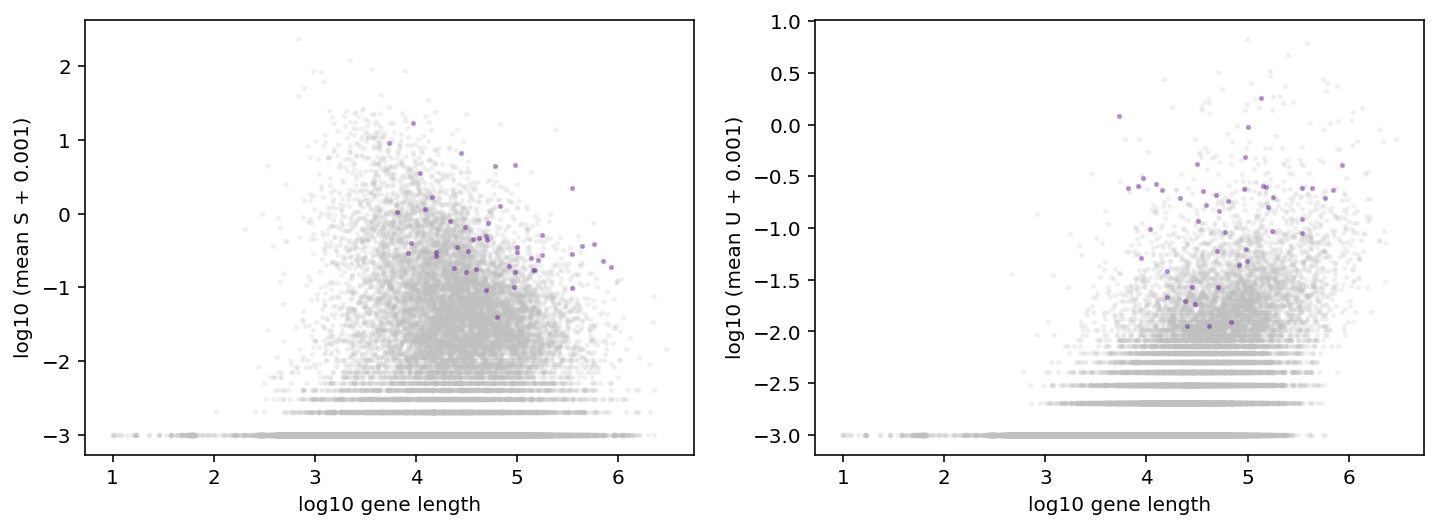

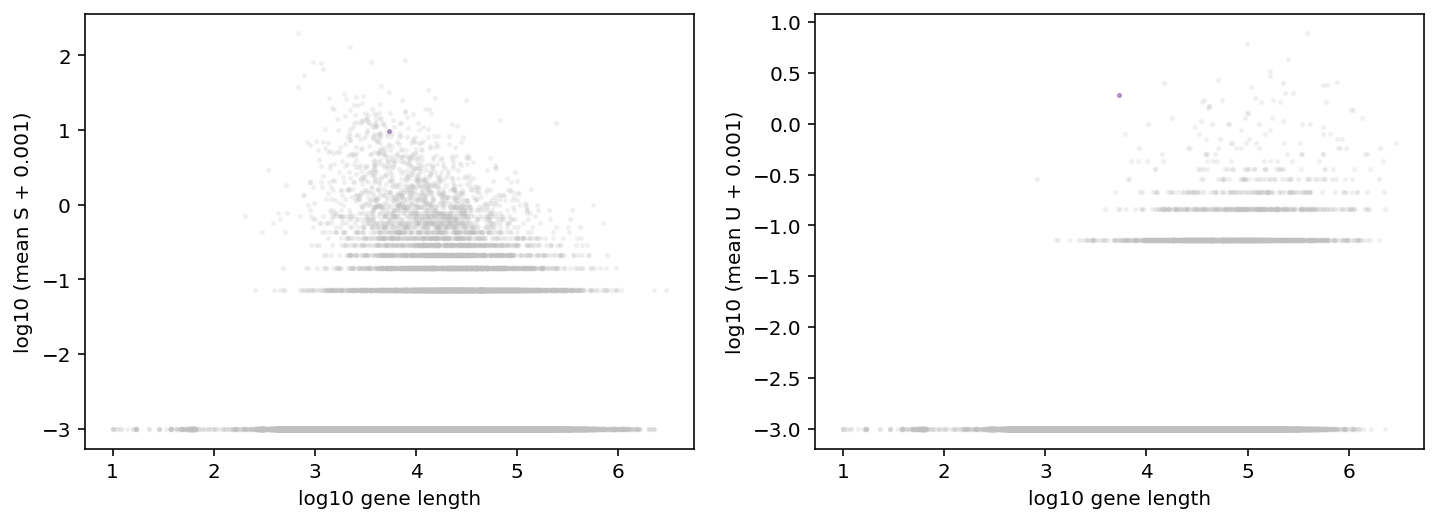

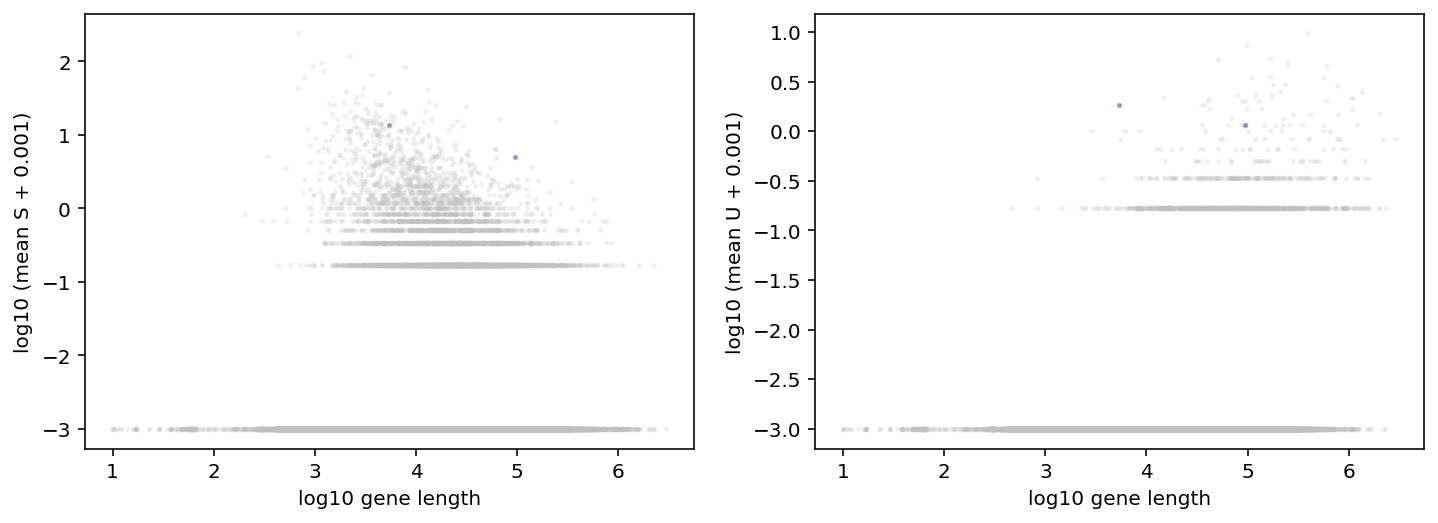

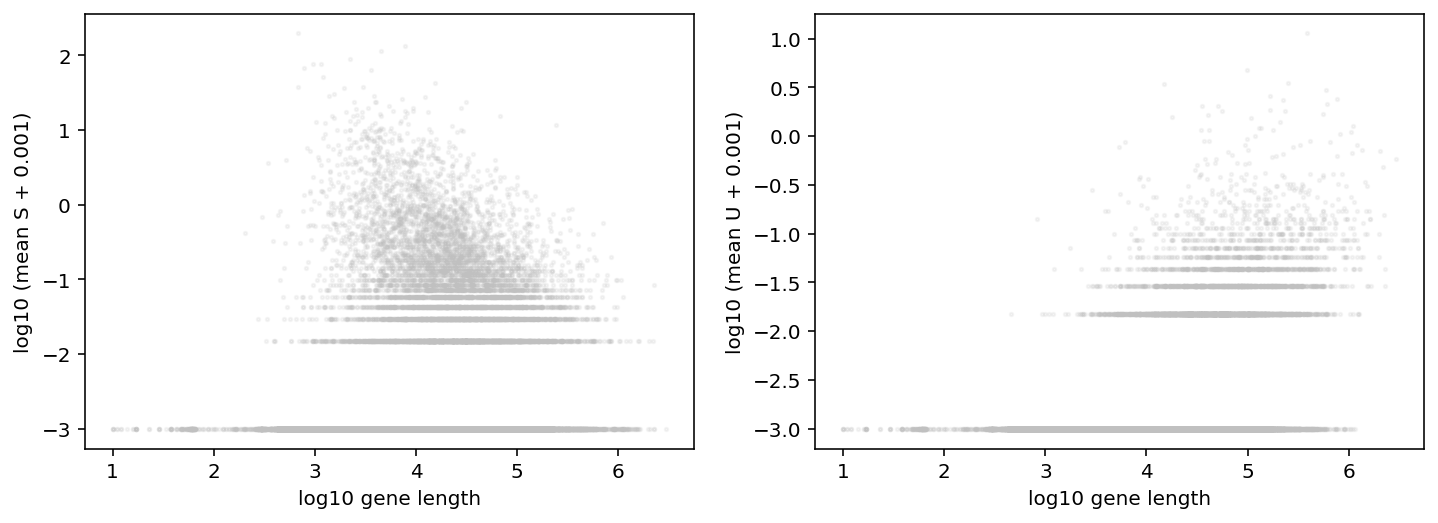

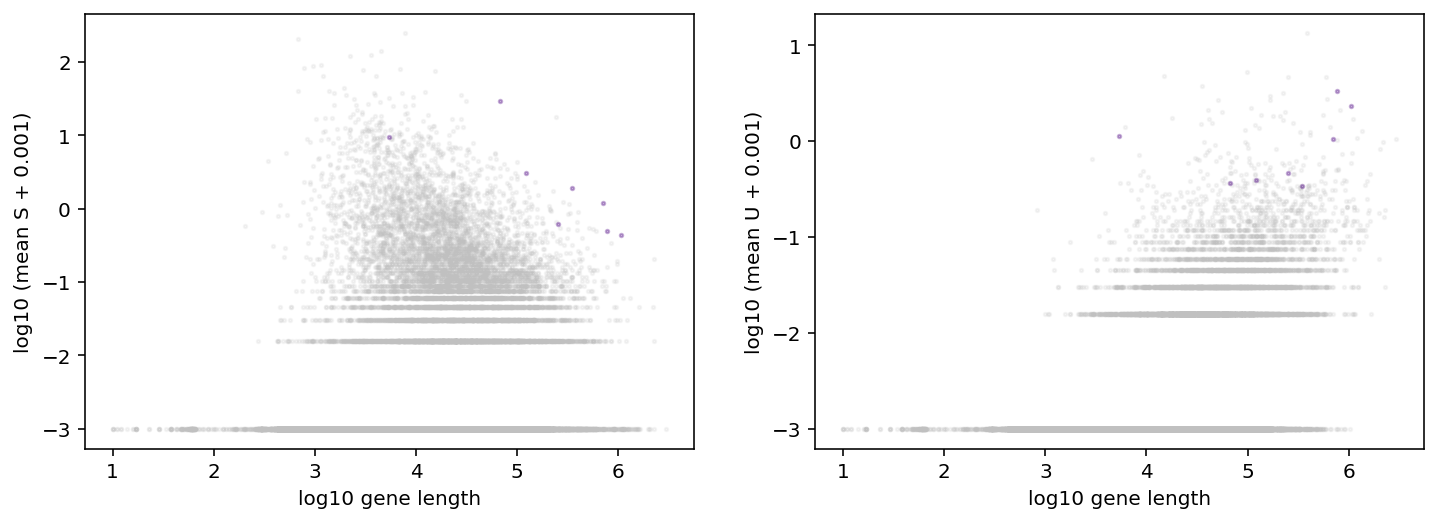

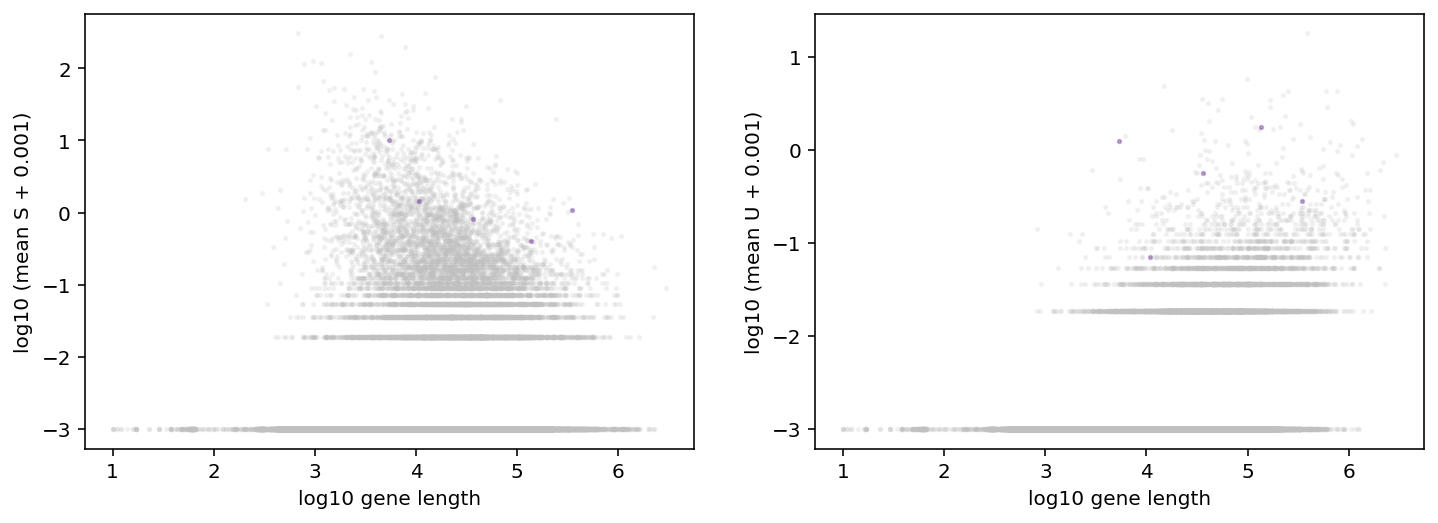

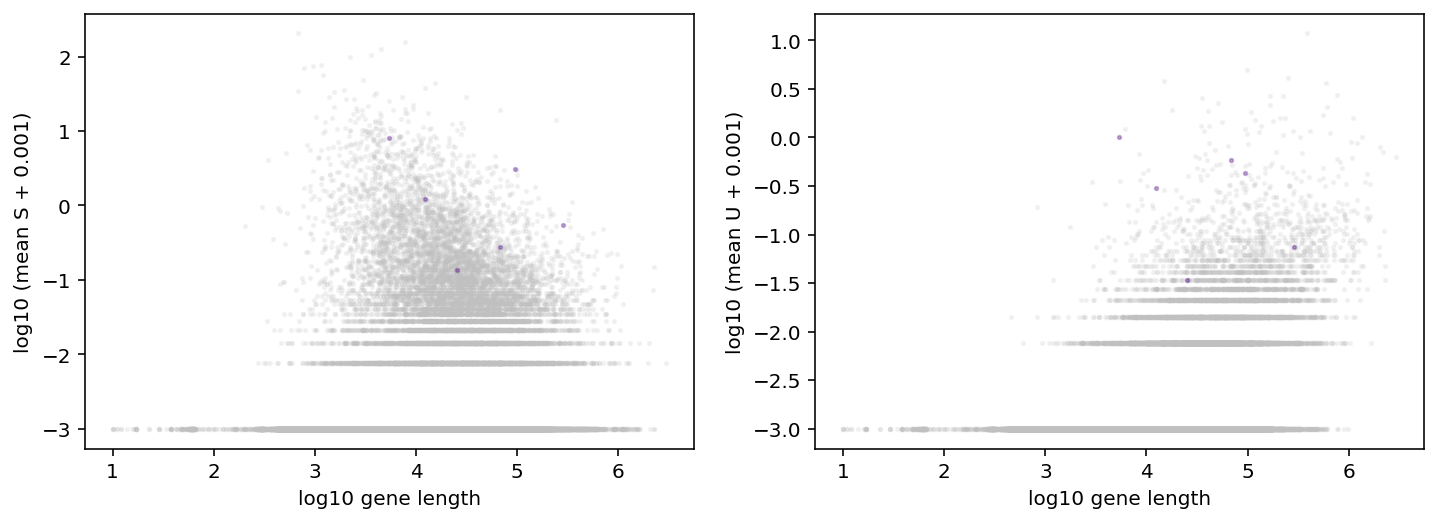

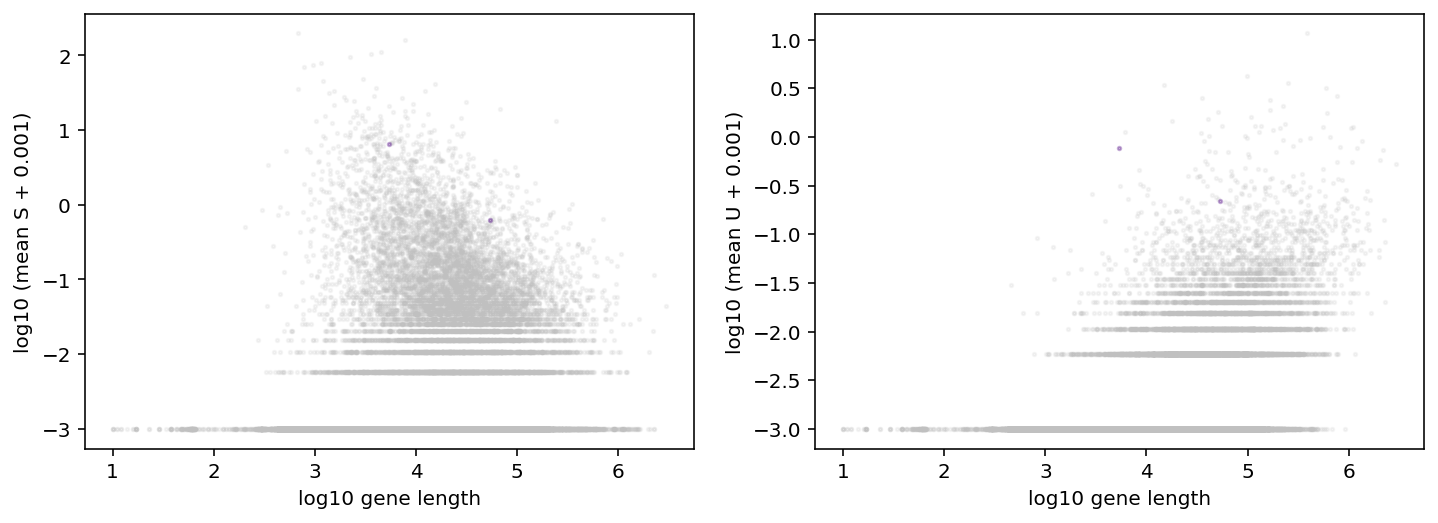

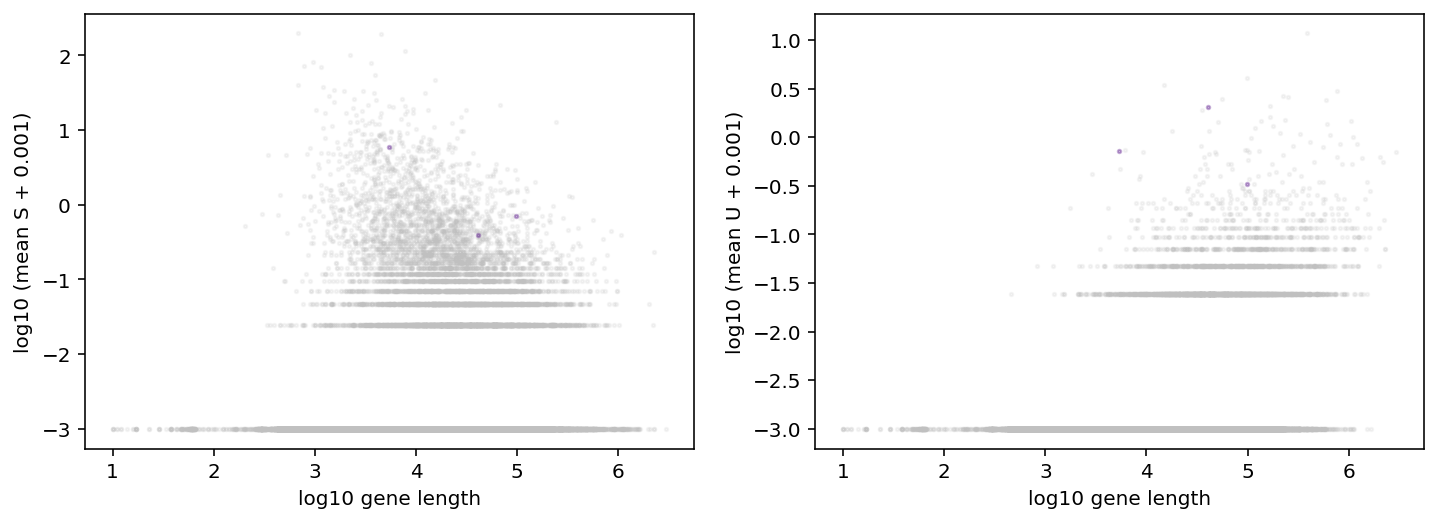

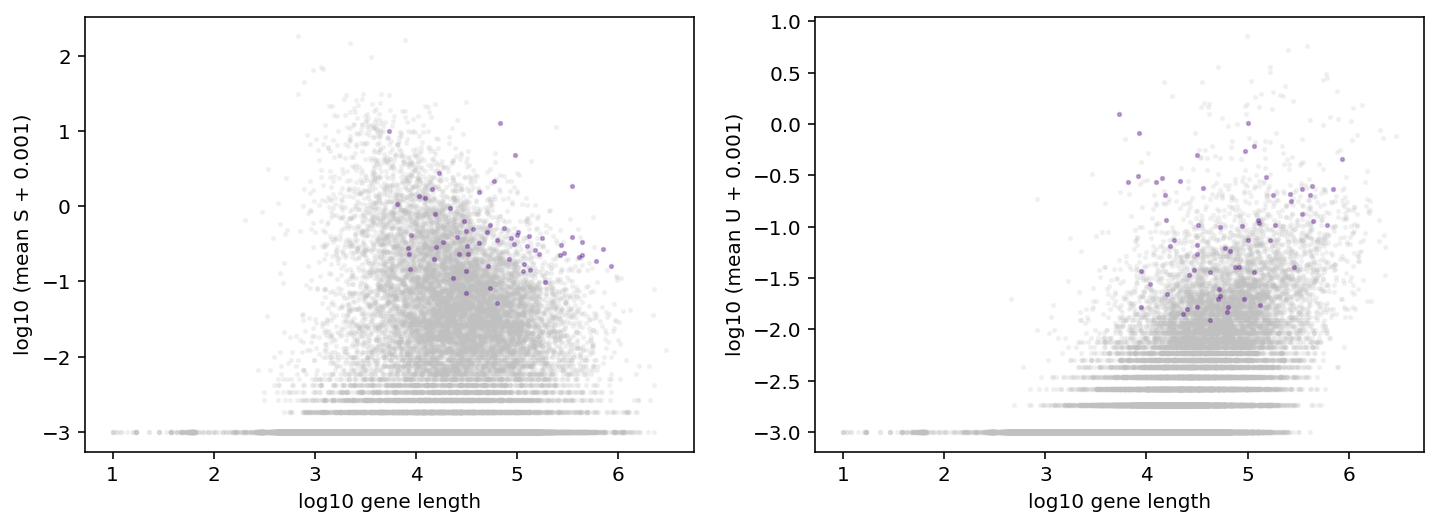

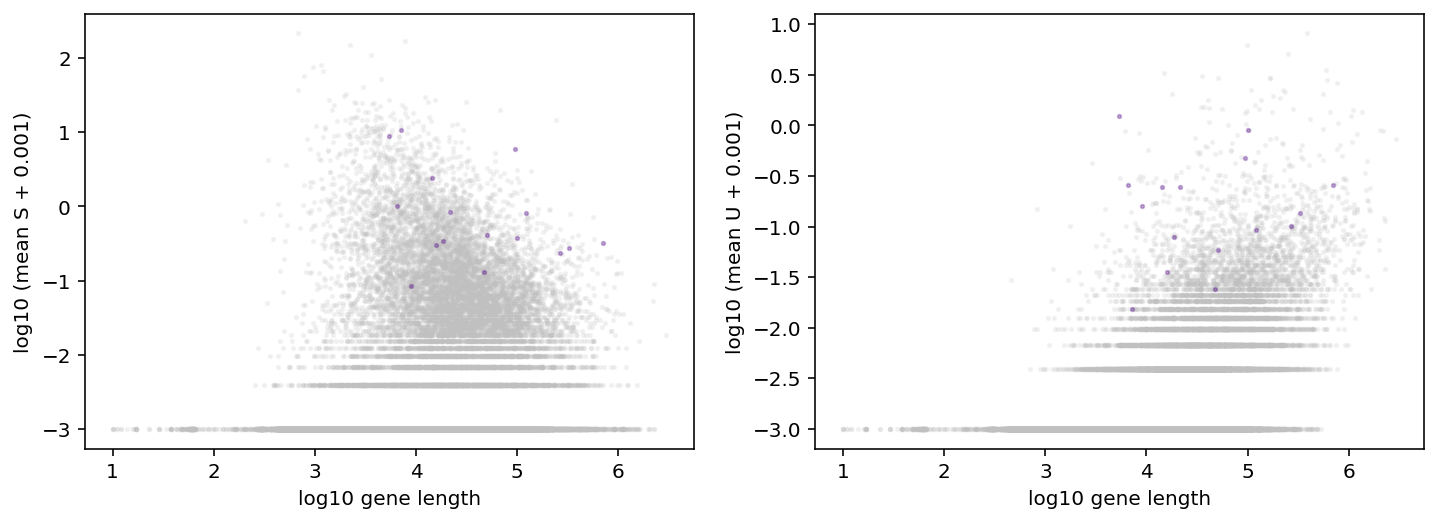

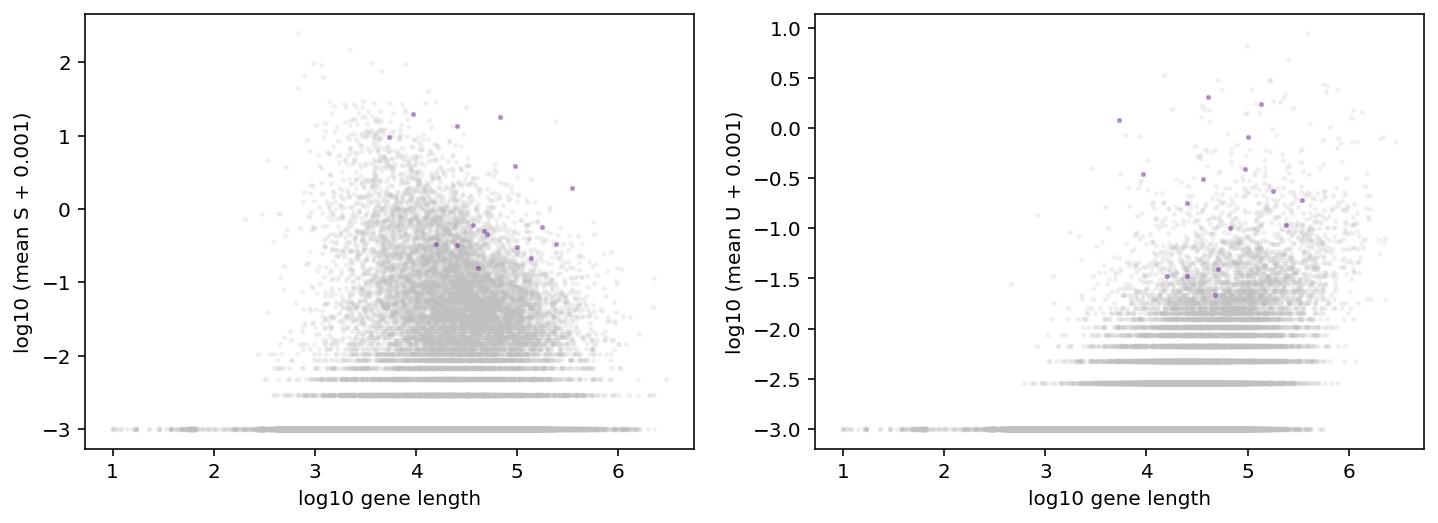

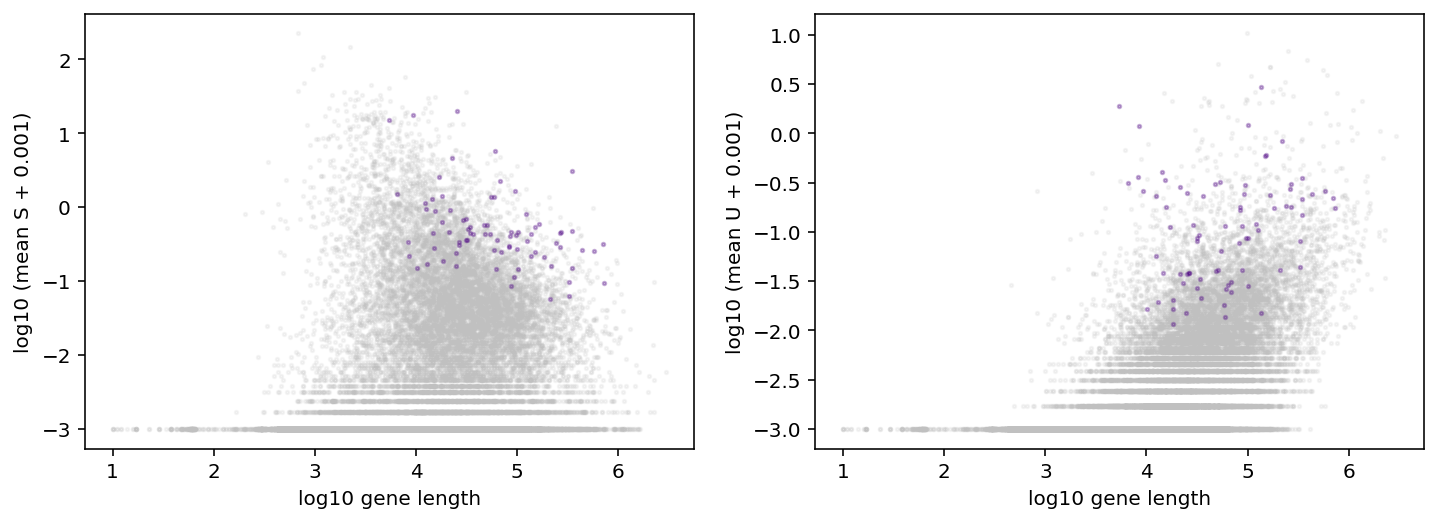

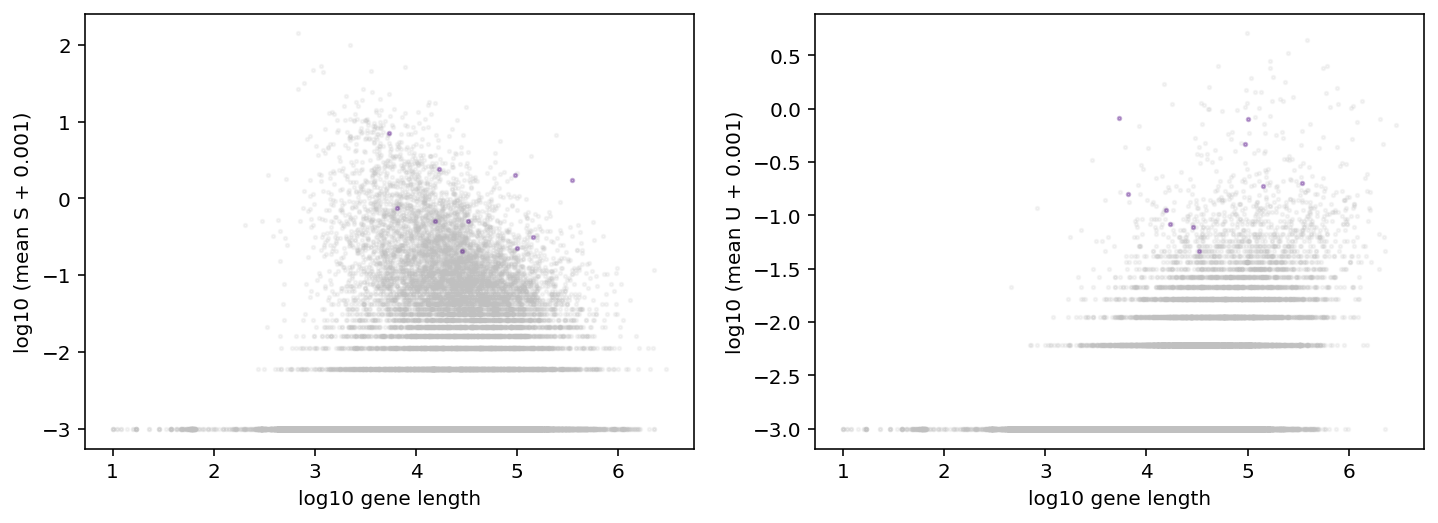

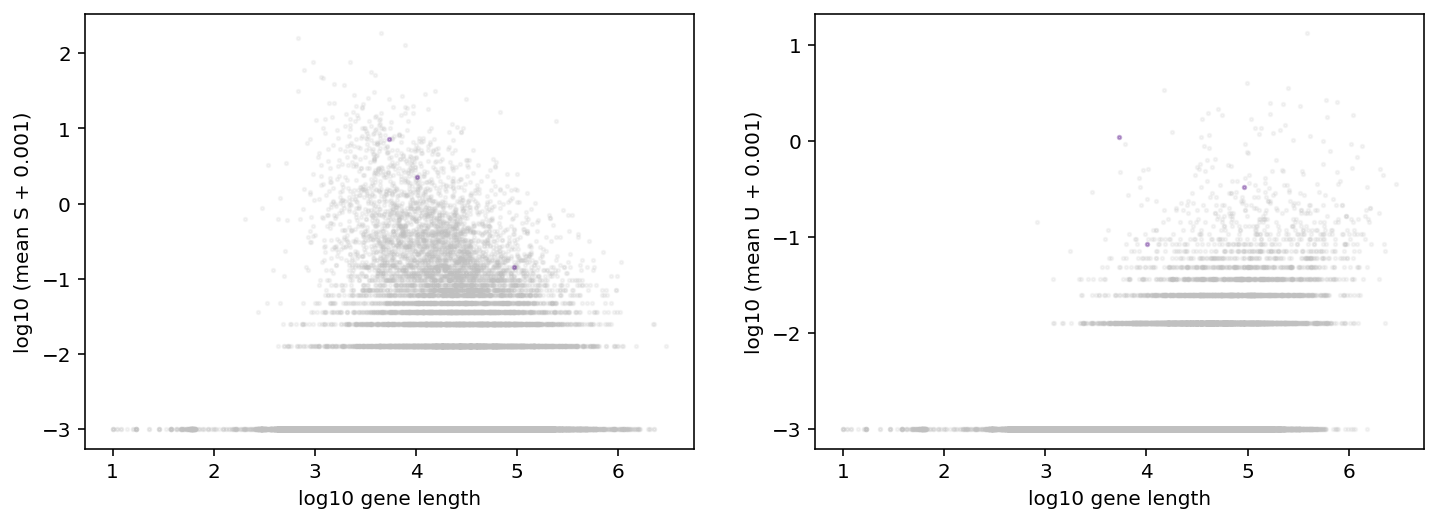

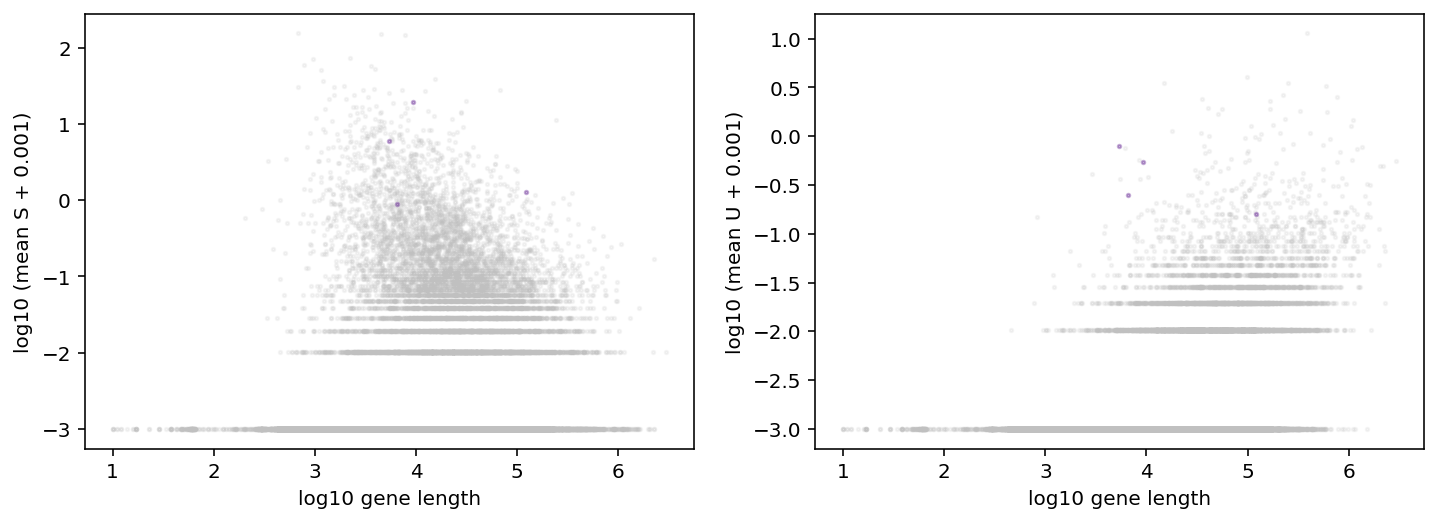

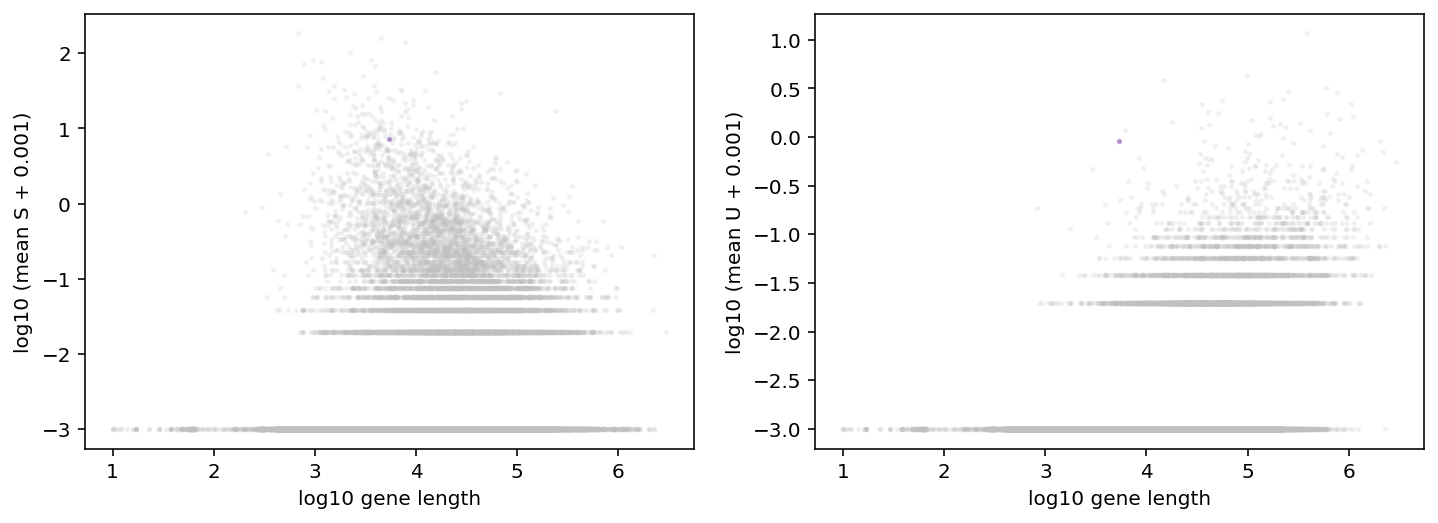

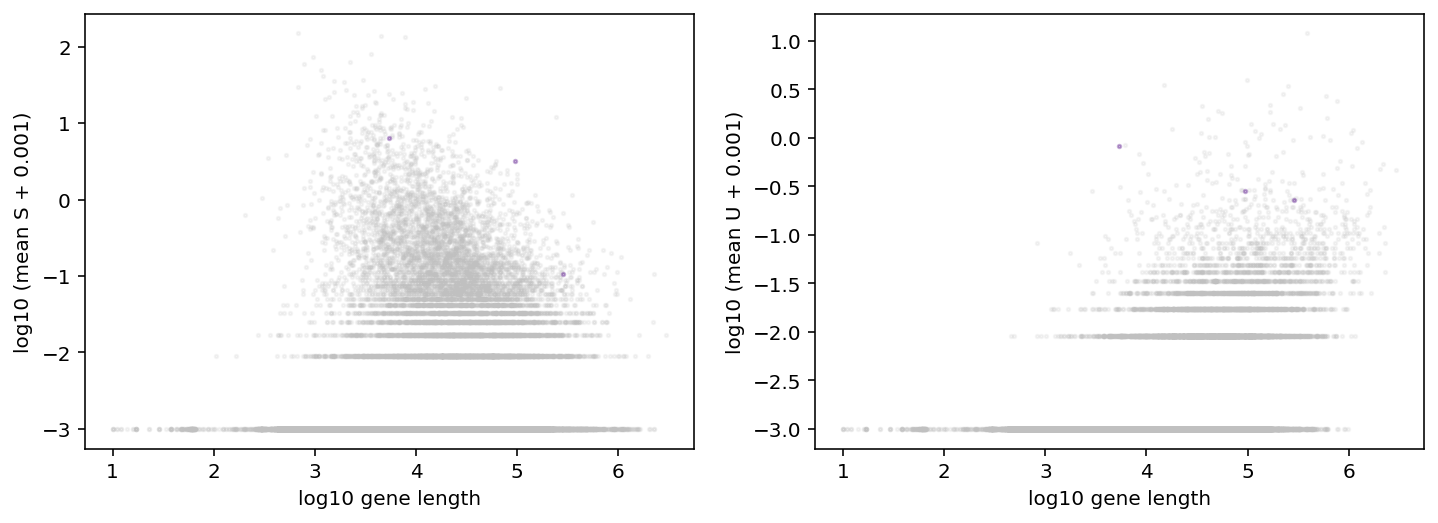

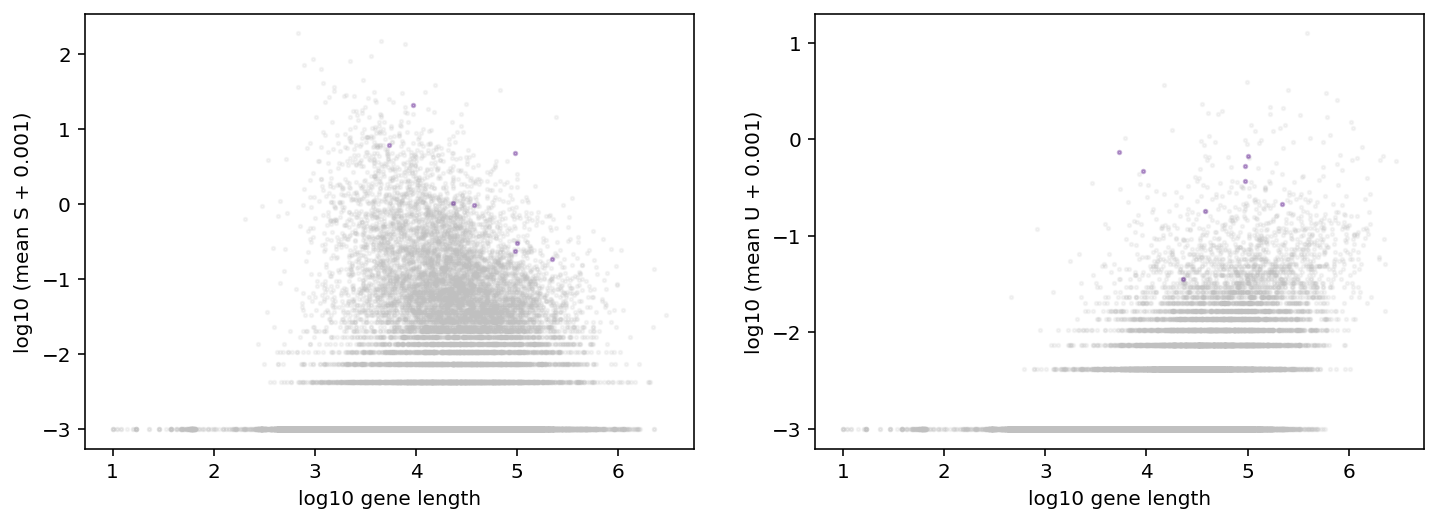

In [ ]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='gehring',batch_id=1,\
                                             n_genes=3000,exp_filter_threshold=None,cf=cf)

In [ ]:
dir_string = './fits/gg_230904_025_gehring_1' #gg_230215_025_norman_crispr_all_1
dataset_strings = [ dir_string+'/'+item for item in os.listdir(dir_string) if os.path.isdir(os.path.join(dir_string, item)) ]


## **Run *Monod* Inference**

In [ ]:
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-7.5, -2] #-7.5, -2
samp_ub = [-5.5, 0 #-5.5, 0
# gridsize = [5,6]
gridsize = [10,11]


Only running on a few conditions. Will select a pair of sampling parameters from these, then run all the other conditions.

Using the larger subsamples below.

In [ ]:
result_strings = []
for i in []:
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':10,'init_pattern':'moments','num_restarts':5})
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)

In [ ]:
result_strings = [i+'/Bursty_Poisson_1x1/grid_scan_results.res' for i in dataset_strings]
print(result_strings[0])

In [ ]:

for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    sr.plot_landscape(ax1)

    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd,threshold=1e-3)
    sr.resample_opt_viz()
    sr.resample_opt_mc_viz()
    sr.chisq_best_param_correction(sd,Ntries=4,viz=False,threshold=1e-3) 

    sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=False,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    

In [ ]:
#Read back in data
sr_arr = [monod.analysis.load_search_results(r[:-4]+'_upd.res') for r in result_strings]

In [ ]:
xl = np.asarray([sr.sp.samp_lb[0],sr.sp.samp_ub[0]])
yl = np.asarray([sr.sp.samp_lb[1],sr.sp.samp_ub[1]])
x=np.linspace(xl[0],xl[1],sr.sp.gridsize[0])
y=np.linspace(yl[0],yl[1],sr.sp.gridsize[1])

In [ ]:
fs = 20
d=0.1

fig1,ax1 = plt.subplots(1,1,figsize=(8,8))
for i in range(sr.sp.gridsize[0]):
    plt.plot([x[i]]*2,yl + [-d,d],c='whitesmoke')
for i in range(sr.sp.gridsize[1]):
    plt.plot(xl+ [-d,d],[y[i]]*2,c='whitesmoke')
jit = np.random.randn(n_datasets,2)*0.01
opt_ = opt+jit
cmap = 'cool'

# ctf = range(6,n_datasets)
# plt.scatter(opt_[ctf,0],opt_[ctf,1],100,n_cells[ctf],zorder=1000,
#             alpha=0.3,cmap=cmap,label='Cell types',vmin=0,vmax=5000)

stf = range(n_datasets) #-1 to exclude combo control

plt.scatter(opt_[stf,0],opt_[stf,1],80,n_cells[stf],marker='^',zorder=1000,
            alpha=0.5,cmap=cmap,label='gRNAs',vmin=0,vmax=5000)
plt.xlim(xl+ [-d,d])
plt.ylim(yl+ [-d,d])

plt.legend(fontsize=fs,loc='upper right')
plt.colorbar(label='Number of cells')

plt.xlabel(r'$\log_{10} C_N$',fontsize=fs)
plt.ylabel(r'$\log_{10} \lambda_M$',fontsize=fs)

fig_string = sr.batch_analysis_string+'/landscape_qc.png'
plt.savefig(fig_string,dpi=450)